In [663]:
# load a matrix from a space-separated file and show it as an image
import sys
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/')
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from optimise_clnn import load_subject_data



In [664]:
def load_adaptation_trace(file_path): 
        df = pd.read_csv(file_path)
        arr = df.Adaptation.to_numpy()
        return arr

In [665]:
LOSS_IS_PER_SAMPLE = False
result_root = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/'
coin_bics_path = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/coin_bics.txt'
paradigm_ = {k: 'evoked' if k <= 8 else 'spontaneous' for k in range(1,17)}
coin_bics = np.loadtxt(coin_bics_path)
# exp_datasets = [ load_adaptation_trace(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv') for i in range(1,17)]
exp_datasets = []
loss_traces= {}
output_traces= {}
prior_out_batch = {}
posterior_out_batch = {}
for i in range(1,25): 
    exp_datasets.append(load_subject_data(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_memory_updating_participant{i}.csv'))
    for j in range(1,2):
        # result_dir = f'mem_upd_try3/run_participant{i}_seed{j}' 
        result_dir = f'mem_upd_try5/run{i}_seed{j}' 
        aux_result_dir = f'mem_upd_try3Final/run{i}_seed{j}'
        try: 
            loss_traces[(i,j)] = np.genfromtxt(f'{result_root}/{result_dir}/loss.csv', delimiter=',')
            output_traces[(i,j)] = np.loadtxt(f'{result_root}/{result_dir}/pred_a.txt')
            # posterior_out_batch[(i,j)] = np.load(f'{result_root}/{aux_result_dir}/pred_a_batch.npz')
            # prior_out_batch[(i,j)] = np.load(f'{result_root}/{aux_result_dir}/prior_a_batch.npz')
        except:
            print(f'Could not load results for run {i} seed {j}')
            loss_traces[(i,j)] = None
            output_traces[(i,j)] = None

Could not load results for run 13 seed 1
Could not load results for run 14 seed 1
Could not load results for run 15 seed 1
Could not load results for run 16 seed 1
Could not load results for run 17 seed 1
Could not load results for run 18 seed 1
Could not load results for run 19 seed 1
Could not load results for run 20 seed 1
Could not load results for run 21 seed 1
Could not load results for run 22 seed 1
Could not load results for run 23 seed 1
Could not load results for run 24 seed 1


/tmp/ipykernel_956706/3662521155.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


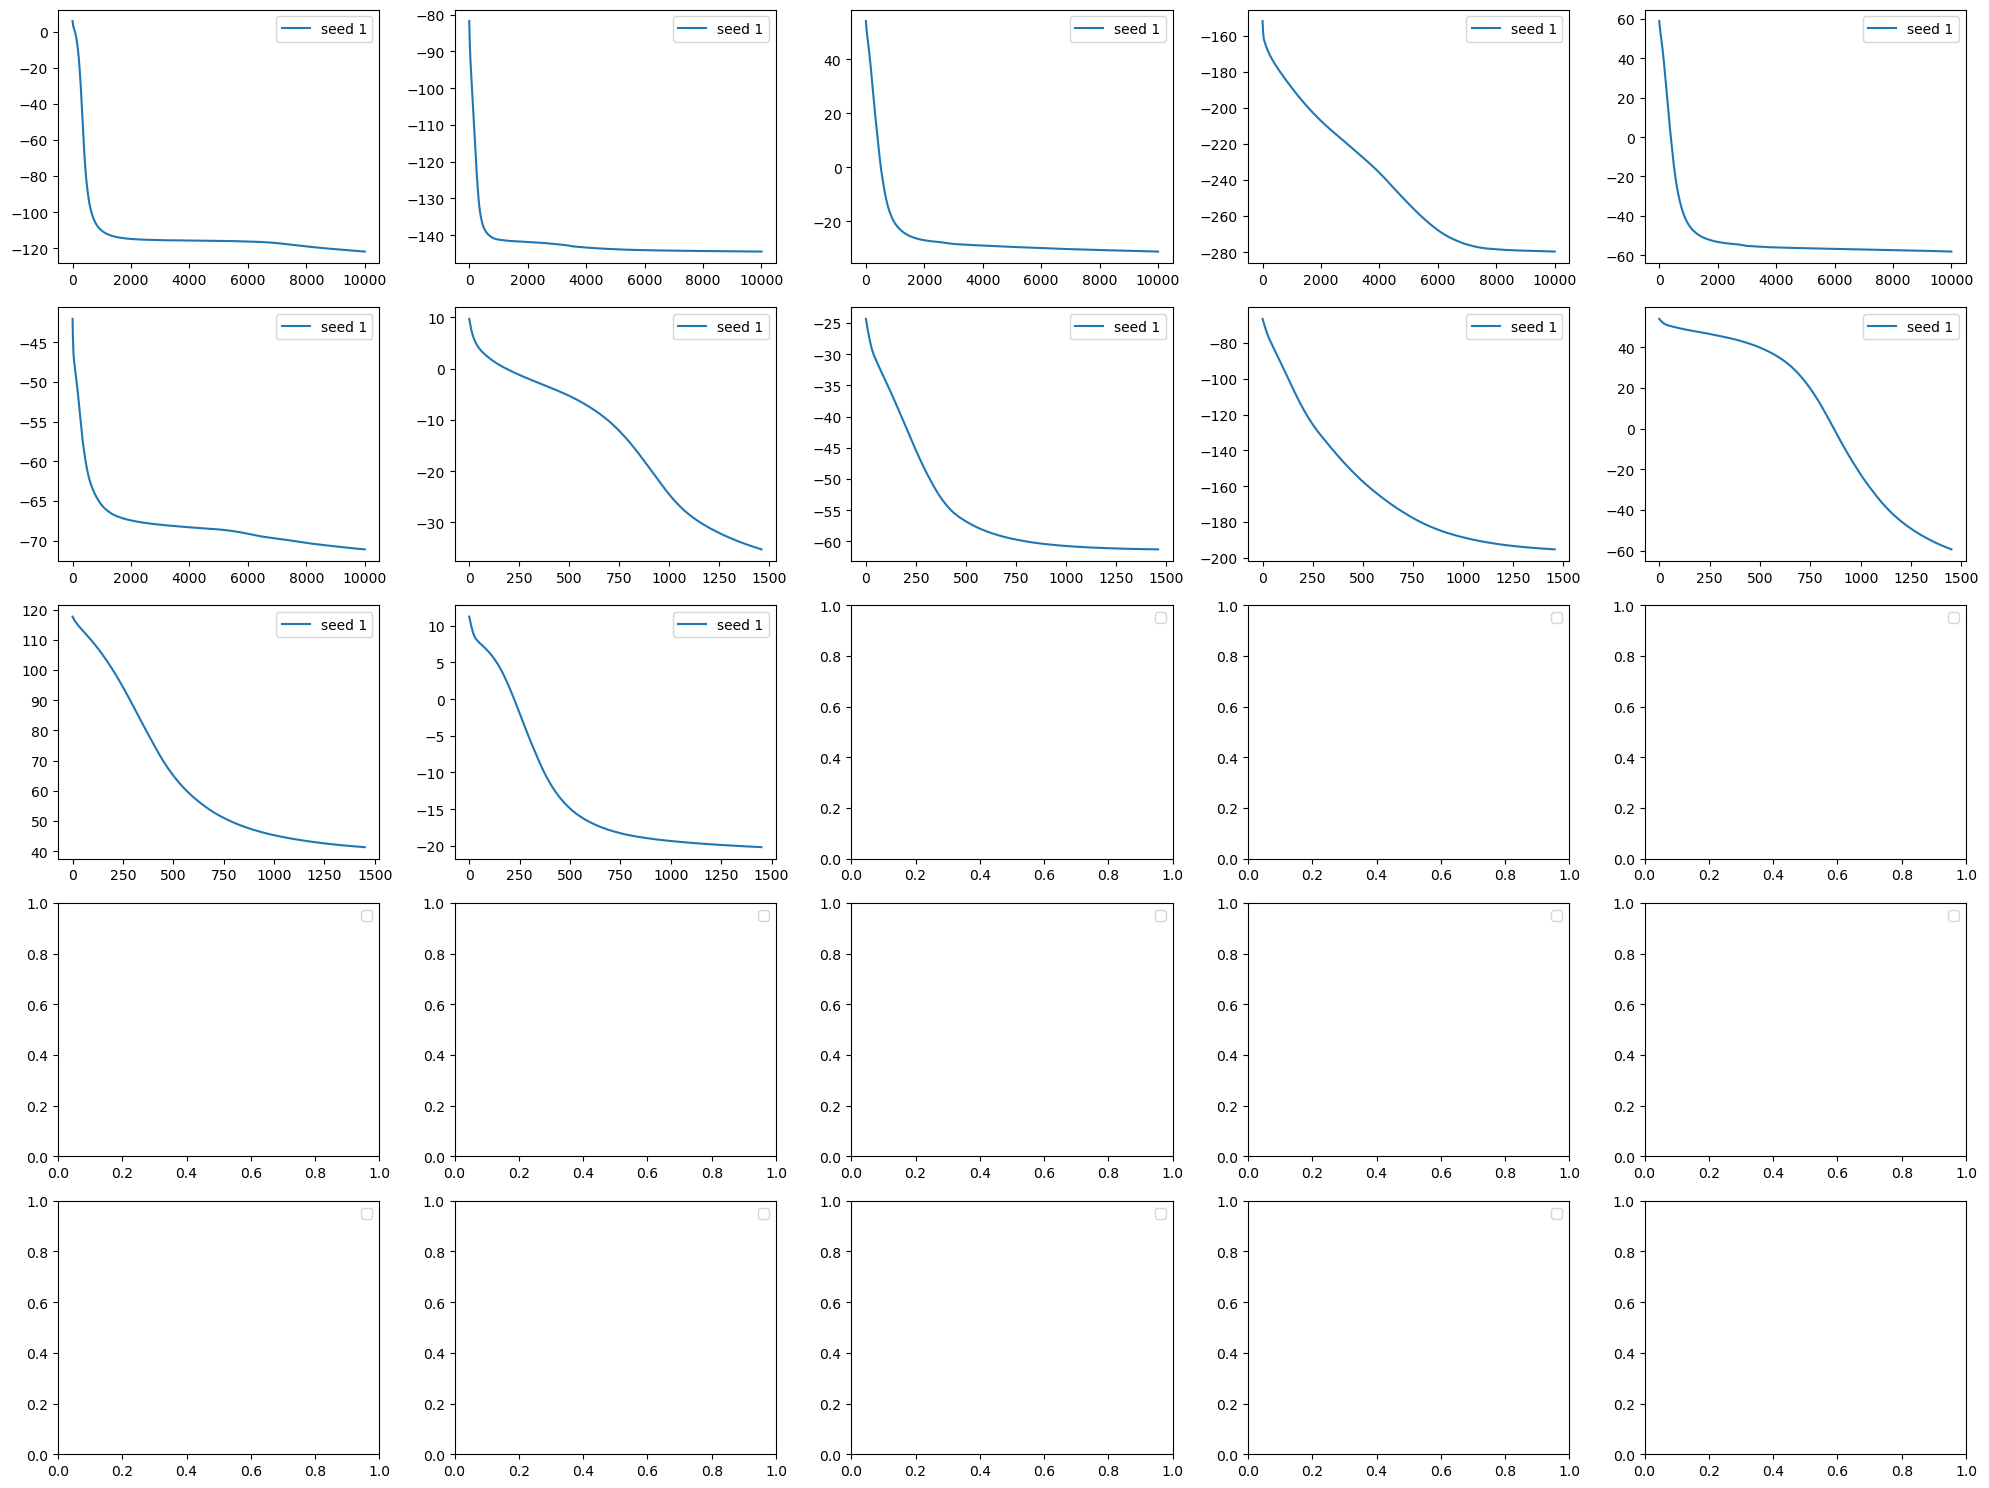

In [666]:
#plot all the loss traces. subplot per run and line per seed
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(1,25):
    ax = axs[(i-1)//5, (i-1)%5]
    for j in range(1,2):
        if loss_traces[(i,j)] is not None:
            ax.plot(loss_traces[(i,j)][:,0],loss_traces[(i,j)][:,-1], label=f'seed {j}')
    # ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
plt.tight_layout()
plt.show()

(1130.0, 1160.0)

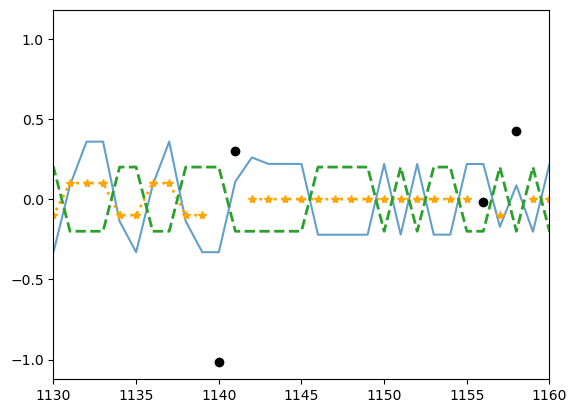

In [667]:
i = 3
plt.plot(exp_datasets[i-1][0], 'o', label='experimental', color='black', linewidth=2)
# plt.plot(mean_as[i-1], '-x', label='prior mean a', color='blue', alpha=0.5)
plt.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
plt.plot(0.1*exp_datasets[i-1][1], ':*', label='experimental', color='orange', linewidth=2)
plt.plot(0.2*exp_datasets[i-1][2], '--', label='experimental', color='tab:green', linewidth=2)
# plt.xlim([2100, 2150])
plt.xlim([1130, 1160])

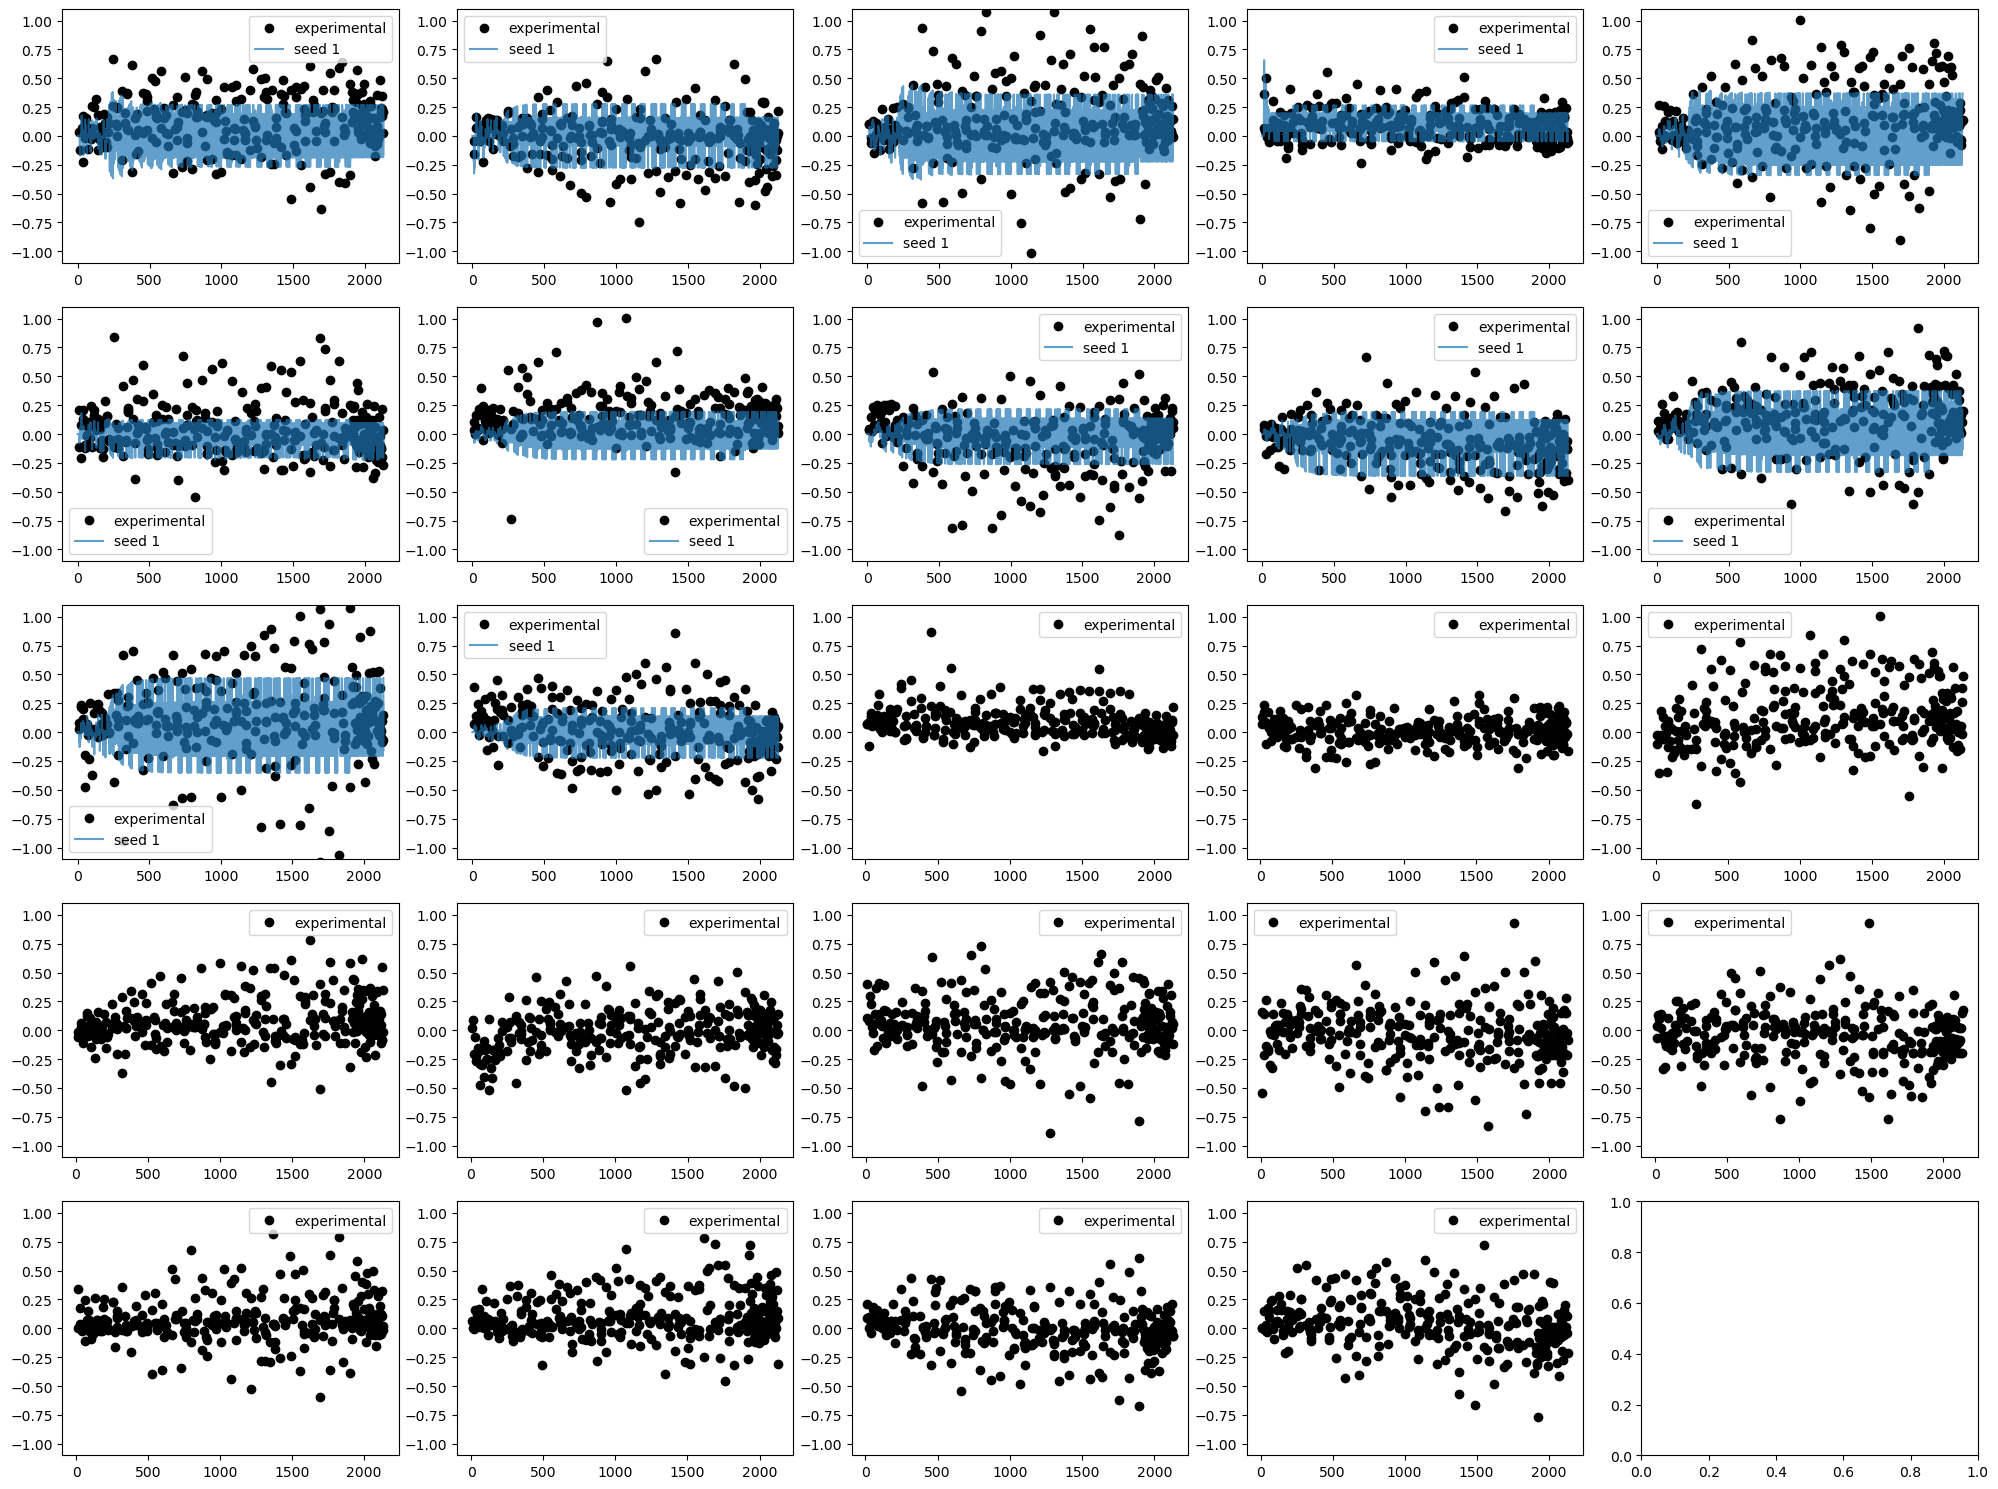

In [668]:
#plot output traces vs experimental data. subplot per run and line per seed
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(1, 25):
    ax = axs[(i-1)//5, (i-1)%5]
    ax.plot(exp_datasets[i-1][0], 'o', label='experimental', color='black', linewidth=2)
    for j in range(1,2):
        # ax.plot(mean_as[i-1], label='prior mean a', color='blue', alpha=0.5)
        if output_traces[(i,j)] is not None:
            ax.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
        
    # ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
    ax.set_ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()

In [669]:
def polarity(ys=None, qs=None):
    '''
    Determine the main polarity of a run of trials with the same force field direction.
    Args:
        ys: applied forces (numpy array)
        qs: sensory cues (numpy array)
    Returns:
        main_polarity: +1 or -1
    Raises:
        ValueError: if mixed polarities are found in the same run
    '''
    iys_blocks = np.concatenate([ys[:-1] == ys[1:], [ys[-2] == ys[-1]]])
    polarities = qs[iys_blocks] * ys[iys_blocks]
    main_polarity = np.sign(np.sum(polarities))
    if np.any(np.isclose(polarities, -main_polarity)):
            raise ValueError('Mixed polarities in same run!')
    return main_polarity

def extract_mem_updates(ys, qs, aa, range_of_triplets):
    '''
    Extracts memory updates from the output traces, according to COIN paper Fig.3.
    Args:
        ys: applied forces (numpy array)
        qs: sensory cues (numpy array)
        aa: experimental/modeled adaptation levels (numpy array)
        range_of_triplets: list of start indexes of triplets
            if a negative integer is given, it is taken as the number of triplets to extract from the end of data
            if a positive integer is given, it is taken as the number of triplets to extract from the start of data
            if list is given - applies to the given indexes
    
    Returns:
        outs: 4 D numpy array with outputs corresponding to averages over a3-a1
        where a1, a2, a3 are adaptation levels for the triplet trials computed for each of the following combinations of (y2,q2): (1,1) (1,-1) (-1,1) (-1,-1)
    '''

    #align all the polarities according to qs (so that q=+1 corresponds to positive y)
    polarity_main = 1 #polarity(ys, qs)
    ys = ys * polarity_main
    # qs = qs * polarity_main
    aa = aa * polarity_main
    #create list of all the start indexes of triplets of (np.nan, some non-nan, np.nan) in ys: 
    start_indexes = []
    for i in range(len(ys) - 2):
        if np.isnan(ys[i]) and not np.isnan(ys[i + 1]) and np.isnan(ys[i + 2]):
            start_indexes.append(i)
    if isinstance(range_of_triplets, int):
        if range_of_triplets < 0:
            start_indexes = start_indexes[range_of_triplets:]
        else:
            start_indexes = start_indexes[:range_of_triplets]
    elif isinstance(range_of_triplets, list):
        start_indexes = [start_indexes[i] for i in range_of_triplets]

    #if we understood the paper correctly then all the q1 and q3 should be equal
    if not np.isclose(qs[start_indexes], qs[start_indexes[0]]).all() or not np.isclose(qs[np.array(start_indexes)+2], qs[start_indexes[0]]).all():
        raise ValueError('q1 and q3 values in triplets are not as expected! They should all be equal.')

    # print(f'using start indexes: {start_indexes}')
    #create 4 D array to hold outputs
    outs_ = [[] for _ in range(4)]
    for idx, start_idx in enumerate(start_indexes):
        #all triplets should have q=+1 at the beginning and end
        # if not (np.isclose(qs[start_idx], 1) and np.isclose(qs[start_idx + 2], 1)):
        #     raise ValueError(f'q values in triplet are not as expected! Found: q1={qs[start_idx]}, q3={qs[start_idx + 2]}, for triplet starting at index {start_idx}')
        #get y2 and q2
        y2 = ys[start_idx + 1]
        q2 = qs[start_idx + 1]
        #determine which of the 4 combinations it is
        if not np.isclose(qs[start_idx], qs[start_idx + 2]):
            raise ValueError(f'q values in triplet are not as expected! Found: q1={qs[start_idx]}, q3={qs[start_idx + 2]}, for triplet starting at index {start_idx}')
        q1 = qs[start_idx] #polarity_main # or =1, depends on how we understand the polarity alignment
        if np.isclose(y2, 1) and np.isclose(q2, 1*q1):
            comb_idx = 0
        elif np.isclose(y2, 1) and np.isclose(q2, -1*q1):
            comb_idx = 1
        elif np.isclose(y2, -1) and np.isclose(q2, 1*q1):
            comb_idx = 2
        elif np.isclose(y2, -1) and np.isclose(q2, -1*q1):
            comb_idx = 3
        else:
            raise ValueError('y2 and q2 values in triplet are not binary!')
        #store the corresponding a3 - a1 in the list
        a1 = aa[start_idx]
        a3 = aa[start_idx + 2]
        outs_[comb_idx].append(a3 - a1)
    # outs_ = [np.array(o) for o in outs_]
    return np.array(outs_)
        
    
    

In [670]:
outs = []
fit_outs = []
for i in range(1, 25):
            ys = exp_datasets[i-1][1]
            qs = exp_datasets[i-1][2]
            aa = exp_datasets[i-1][0]
            outs.append(extract_mem_updates(ys, qs, aa,-32))
            # fit_outs.append(extract_mem_updates(ys, qs, mean_as[i-1],-32))
            try:
                fit_outs.append(extract_mem_updates(ys, qs, output_traces[(i,1)],-32))
            except:
                # fit_outs.append(None)
                pass


(-0.2, 0.5)

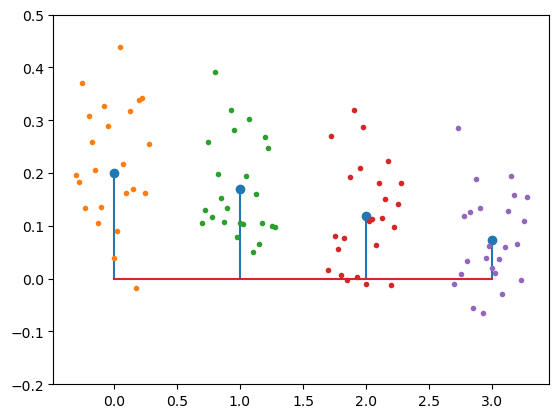

In [671]:
y_alignment = np.array([1,1,-1,-1])
plt.stem(y_alignment * np.mean(outs, axis=-1).mean(axis=0), 'x')
for ii in range(4):
    xdata = -0.3+0.6/24*np.arange(24) + ii
    ydata = y_alignment[ii] * np.mean(outs, axis=-1)[:,ii]
    plt.plot(xdata, ydata,'.')
plt.ylim([-0.2, 0.5])

(-0.2, 0.5)

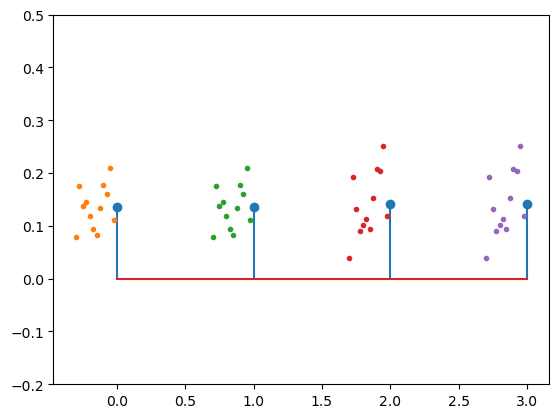

In [672]:
y_alignment = np.array([1,1,-1,-1])
plt.stem(y_alignment * np.mean(fit_outs, axis=-1).mean(axis=0), 'x')
for ii in range(4):
    ydata = y_alignment[ii] * np.mean(fit_outs, axis=-1)[:,ii]
    xdata = -0.3+0.6/24*np.arange(len(ydata)) + ii
    plt.plot(xdata, ydata,'.')
plt.ylim([-0.2, 0.5])

In [673]:
def consistency(ys=None, qs=None):
    iys_blocks = np.concatenate([ys[:-1] == ys[1:], [ys[-2] == ys[-1]]])
    consistency = ys[:-1] * ys[1:] * iys_blocks[:-1] * iys_blocks[1:] 
    consistency = consistency[iys_blocks[1:]]
    return np.nanmean(consistency)

In [674]:
for i in range(1, 25):
    ys = exp_datasets[i-1][1]
    qs = exp_datasets[i-1][2]
    print(f'Run {i} consistency: {consistency(ys, qs)}')

Run 1 consistency: 0.1063627730294397
Run 2 consistency: 0.11132437619961612
Run 3 consistency: 0.13475836431226765
Run 4 consistency: 0.13079777365491652
Run 5 consistency: 0.0977948226270374
Run 6 consistency: 0.10096153846153846
Run 7 consistency: 0.13577981651376148
Run 8 consistency: 0.12
Run 9 consistency: 0.116991643454039
Run 10 consistency: 0.10384615384615385
Run 11 consistency: 0.11329588014981273
Run 12 consistency: 0.11929170549860205
Run 13 consistency: 0.11490978157644824
Run 14 consistency: 0.11090047393364928
Run 15 consistency: 0.11742777260018639
Run 16 consistency: 0.10426540284360189
Run 17 consistency: 0.1315042573320719
Run 18 consistency: 0.12301957129543337
Run 19 consistency: 0.12313432835820895
Run 20 consistency: 0.11943127962085308
Run 21 consistency: 0.10707635009310987
Run 22 consistency: 0.10361216730038023
Run 23 consistency: 0.10921177587844255
Run 24 consistency: 0.10450623202301054


In [675]:
params = torch.load(f'{result_root}/mem_upd_try5/run1_seed1/params.pt')

In [676]:
params

OrderedDict([('gen.log_learning_rate', tensor([-5.0657], device='cuda:0')),
             ('gen.log_learning_rate_decay',
              tensor([-0.7500], device='cuda:0')),
             ('gen.sigma_b', tensor([0.8355], device='cuda:0')),
             ('gen.output_scale', tensor([0.3500], device='cuda:0')),
             ('gen.sp_weight_decay', tensor([-3.6141], device='cuda:0')),
             ('gen.q_scale', tensor([1.1016], device='cuda:0')),
             ('gen.sigma_x', tensor([0.0002], device='cuda:0')),
             ('gen.tauelpf_m1', tensor([0.3278], device='cuda:0')),
             ('gen._z_biases',
              tensor([ 0.1696, -1.2966,  0.3153,  0.9196, -0.1853, -1.0896, -0.2633,  0.3830,
                      -0.6385,  1.4271, -1.3746, -0.0525, -0.3421, -2.0838,  2.0190,  0.1966,
                       0.2106,  0.2055,  0.5721,  1.3064, -0.0335,  2.3592,  0.4094,  1.0403,
                       0.4566,  1.0188, -1.2642,  0.4593,  0.5442, -1.7211, -0.5568, -1.3337,
              

In [677]:
for i in range(1, 25):
            # plt.subplot(5,5,i)
            main_polarity = polarity(exp_datasets[i-1][1], exp_datasets[i-1][2])
            print(f'Run {i} main polarity: {main_polarity}')


Run 1 main polarity: 1.0
Run 2 main polarity: -1.0
Run 3 main polarity: -1.0
Run 4 main polarity: 1.0
Run 5 main polarity: -1.0
Run 6 main polarity: 1.0
Run 7 main polarity: 1.0
Run 8 main polarity: -1.0
Run 9 main polarity: 1.0
Run 10 main polarity: 1.0
Run 11 main polarity: -1.0
Run 12 main polarity: -1.0
Run 13 main polarity: 1.0
Run 14 main polarity: -1.0
Run 15 main polarity: 1.0
Run 16 main polarity: -1.0
Run 17 main polarity: -1.0
Run 18 main polarity: 1.0
Run 19 main polarity: 1.0
Run 20 main polarity: -1.0
Run 21 main polarity: -1.0
Run 22 main polarity: 1.0
Run 23 main polarity: -1.0
Run 24 main polarity: 1.0
